### Regressive CNN for agn bending angle calculation

1. Use Garon source sample, with labelled bending angle  
    \- bending angle vs corrected bending angle
2. Image preprocessing and data augmentation
3. Model architecture  
    \- normal CNN with regressive final layer
4. Loss function and optimizer  
    \- MSE, ASE loss functions  
    \- how to measure accruacy / loss of the network  
5. Train model and plot results
6. Generate synthetic training data  
    \- need labelled angle so can't use gan? - put errors on training data?  
    \- get labelled data from paramter simulation  
7. Train model with data boosted by synthetic data

TODO:
1. Early stopping callback
2. Force prediction to be [0,180]
3. Include SDSS galaxy location in model input

In [10]:
from __future__ import absolute_import, division, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import stats
from skimage.transform import resize
from scipy.ndimage import shift, rotate # could use skimage rotate
import sys
import time
#import os
#from astropy.io import fits 

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
## Variables

sigma = 2
crop_size = 50
downsample_size = None
percentage_train = 80
augmentation_size = 20000
synthetic_size = 20000
batch_size = 128
epochs = 30

images: (4287, 150, 150) 
nan_indices: [21, 23, 52, 74, 78, 93, 130, 134, 1458, 3548, 3594, 3597, 3694, 3700, 3718] [552]


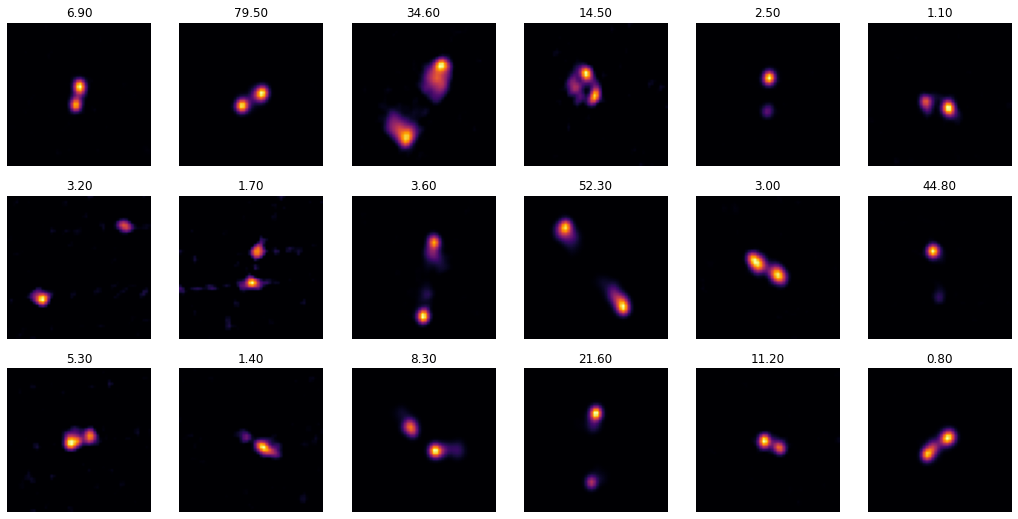

In [12]:
## Data preparation

# Load data
imagepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/garon-combined.npy'
# Had to remake .npy file with sorted list of files in directory so image order matches .tsv order
images, nan_indices = np.load(imagepath, allow_pickle = True)
num_images, image_size, _ = images.shape
print('images:',images.shape,'\nnan_indices:',nan_indices[0], nan_indices[1])

# Load data labels
labelpath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Garon-combined.tsv'
bend_angle = np.loadtxt(labelpath, delimiter='|', usecols=8, skiprows=3)
num_garon_matched = 3723 #(only 3722 downloaded)    #num_garon_unmatched = 581 #(all downloaded)

# Delete label entries corresponding to missing images
del_idxs = nan_indices[0]+[3622]+[nan_indices[1][0]+num_garon_matched] # index 3622 was not downloaded from cutout server
bend_angle = np.delete(bend_angle, del_idxs)
assert len(bend_angle) == len(images)

# Sigma clip images
if sigma != None:
    for i in range(num_images):
        _, median, std = stats.sigma_clipped_stats(images[i], sigma=sigma)
        images[i][images[i] < median+sigma*std] = median+sigma*std

# Crop images
if crop_size != None:
    low_idx, upper_idx = image_size//2-crop_size//2, image_size//2+crop_size//2
    images = images[:, low_idx:upper_idx, low_idx:upper_idx]

# Resize images (downsampling)
if downsample_size != None:
    images = resize(images, (num_images, downsample_size, downsample_size))

# Normalise images [-1,1]
for i in range(num_images):
    images[i] = 2*(images[i]-np.min(images[i]))/np.ptp(images[i])-1

# Plot images with corresponding labels
def show_labelled_images(images, labels, num=18, log=False):
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(18,3*rows))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]
        if log: 
            image = image-np.min(image)+0.01 # make all pixel values positive for log color scale
            plt.imshow(image, cmap='inferno', norm=colors.LogNorm())
        else:
            plt.imshow(image, cmap='inferno')
        plt.title('{:.2f}'.format(labels[i]))
        plt.axis('off')
    plt.show()

show_labelled_images(images[36:], bend_angle)

In [0]:
# Crop images to largest angular size (in arcmin)
las = np.loadtxt(labelpath, delimiter='|', usecols=4, skiprows=3)
# np.max(las) = 1.499
# pixels per arcmin = 150/4.5
# 33.33333*1.499 = 49.9
# 1.499 arcmin = 50 pixels

# Looks very difficult without the position of the host galaxy from SDSS
# Could include the galaxy position in the input
# Or could try using only sources with morphology of 3

In [14]:
# Split into training and test images
shuffle_idxs = np.random.permutation(range(num_images)) # shuffle images so different train, test data for different runs
images = images[shuffle_idxs]
bend_angle = bend_angle[shuffle_idxs]

num_train = int(np.round(num_images*percentage_train/100))
train_images, test_images = np.split(images, [num_train])
train_labels, test_labels = np.split(bend_angle, [num_train])

# Augment images
def augment_data(data, labels, n, method='random'):
    '''
    Augment training data using flips, rotations (and zooms?)
    Keeps track of labels
    Rotation pads with -1, i.e. assumes [-1,1] normalisation
    
    train: tuple of image data with corresponding labels
    n: desired final number of images to augment data to
    method:
        'random': each extra image is a random flip and rotation of a random orginal image
        'ordered': each image is rotated and flipped a constant number of times to reach n images
        
    returns: tuple of augmented image data with corresponding labels
    '''
    start_time = time.time()

    num_images, size, _ = data.shape
    num_extra = n - num_images
    augmented_data = np.empty((n, size, size))
    augmented_labels = np.empty(n)
    augmented_data[:num_images] = data
    augmented_labels[:num_images] = labels
    
    if method == 'random':
        for i in range(num_images, n):
            flip = np.random.choice([True, False])
            angle = 360*np.random.random()
            image_idx = np.random.randint(num_images)
            image = data[image_idx]
            if flip: image = np.fliplr(image)
            augmented_data[i] = rotate(image, angle, reshape=False, cval=-1)
            augmented_labels[i] = labels[image_idx]
            
    elif method == 'ordered':
        rotations_per_image, num_extra_rotation = divmod(num_extra, num_images)
        angles1 = np.linspace(0, 360, rotations_per_image+1, endpoint=False)[1:] # len() = rots_per_image
        angles2 = np.linspace(0, 360, rotations_per_image+2, endpoint=False)[1:]
        angles = np.concatenate((np.tile(angles2, num_extra_rotation),np.tile(angles1, num_images-num_extra_rotation)))
        assert len(angles) == num_extra
        # could use np.repeat instead of nested for loops
        idxs1 = [i for i in range(num_extra_rotation, num_images) for _ in range(rotations_per_image)]
        idxs2 = [i for i in range(num_extra_rotation) for _ in range(rotations_per_image+1)]
        image_idxs = np.concatenate((idxs2, idxs1))
        assert len(angles) == len(image_idxs)
        for i in range(num_extra):
            image = data[image_idxs[i]]
            if i%2 == 0: image = np.fliplr(image)
            augmented_data[i+num_images] = rotate(image, angles[i], reshape=False, cval=-1)
            augmented_labels[i+num_images] = labels[image_idxs[i]]
            
    print('Time for augmentation: {:02d}:{:02d}'.format(*divmod(round(time.time()-start_time), 60)))
    return (augmented_data, augmented_labels)

aug_train_images, aug_train_labels = augment_data(train_images, train_labels, augmentation_size)

# Add a channels dimension (needed for CNN)
# Changes from float 64 to 32 to match default keras layer dtype
aug_train_images = aug_train_images[..., tf.newaxis].astype('float32')
test_images = test_images[..., tf.newaxis].astype('float32')

# Create tf.data.Datset with labels, and shuffle
train_ds = tf.data.Dataset.from_tensor_slices((aug_train_images, aug_train_labels))
train_ds = train_ds.shuffle(len(aug_train_images))

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

print('train images: ', train_images.shape)
print('augmented train images: ', aug_train_images.shape)
print('test images: ', test_images.shape)

Time for augmentation: 00:06
train images:  (3430, 50, 50)
augmented train images:  (20000, 50, 50, 1)
test images:  (857, 50, 50, 1)


In [0]:
## Model training

input_shape = test_images.shape[1:]
print('input shape:',input_shape)

# Alhassan model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(194, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(194, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

history = model.fit(train_ds.batch(batch_size), validation_data=test_ds.batch(batch_size), epochs=epochs)
print('\n')
model.evaluate(test_ds.batch(32), verbose=2)

input shape: (50, 50, 1)
Train for 157 steps, validate for 7 steps
Epoch 1/30
157/157 [==============================] - 11s 71ms/step - loss: 666.7684 - mae: 15.3278 - mse: 665.3198 - val_loss: 664.3316 - val_mae: 13.9247 - val_mse: 671.1180
Epoch 2/30
157/157 [==============================] - 5s 29ms/step - loss: 642.2350 - mae: 15.0209 - mse: 644.1516 - val_loss: 662.6262 - val_mae: 13.4182 - val_mse: 669.1865
Epoch 3/30
157/157 [==============================] - 4s 28ms/step - loss: 607.4906 - mae: 14.6702 - mse: 606.5630 - val_loss: 625.1014 - val_mae: 13.1470 - val_mse: 631.0079
Epoch 4/30
157/157 [==============================] - 4s 28ms/step - loss: 522.5685 - mae: 14.0137 - mse: 524.2205 - val_loss: 479.1690 - val_mae: 13.2952 - val_mse: 484.9688
Epoch 5/30
157/157 [==============================] - 4s 28ms/step - loss: 465.6294 - mae: 13.2466 - mse: 463.7396 - val_loss: 638.3304 - val_mae: 17.7087 - val_mse: 644.9911
Epoch 6/30
157/157 [==============================] - 4s 

[424.2502661810981, 12.785967, 421.2028]

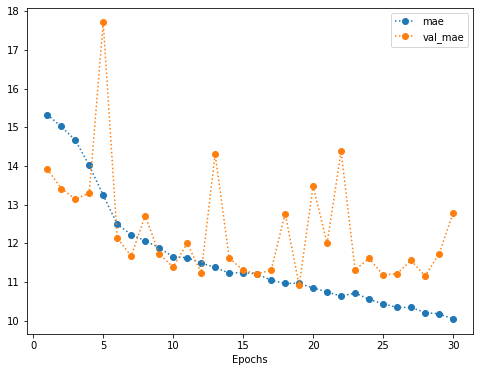

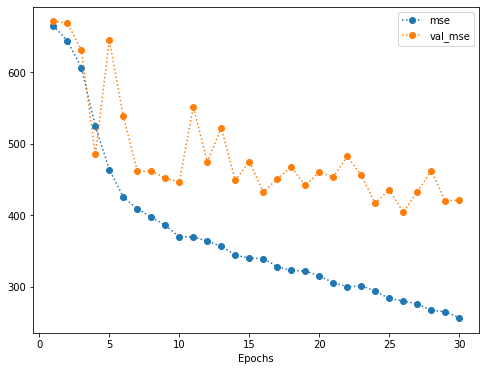

In [0]:
## Plot metrics

history_dict = history.history
#print('history_dict keys:', history_dict.keys())

# loss = history_dict['loss']
# val_loss = history_dict['val_loss']
# mae = history_dict['mae']
# val_mae = history_dict['val_mae']
# mse = history_dict['mse']
# val_mse = history_dict['val_mse']

def plot_metric(epochs, metrics):
    plt.figure(figsize=(8,6))
    for m in metrics:
        metric = history_dict[m]
        plt.plot(range(1,epochs+1), metric, 'o:', label=m)
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# plot_metric(epochs, ('loss', 'val_loss'))
plot_metric(epochs, ('mae', 'val_mae'))
plot_metric(epochs, ('mse', 'val_mse'))

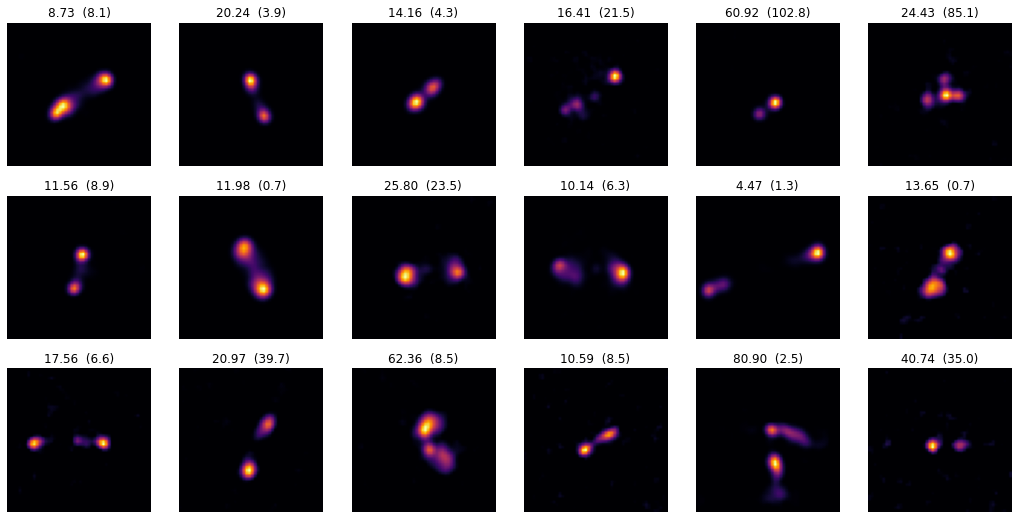

In [0]:
test_predictions = model.predict(test_images)
test_predictions = np.squeeze(test_predictions)

def show_image_predictions(images, labels, predictions, num=18, log=False):
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(18,3*rows))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i,:,:,0]
        if log: 
            image = image-np.min(image)+0.01 # make all pixel values positive for log color scale
            plt.imshow(image, cmap='inferno', norm=colors.LogNorm())
        else:
            plt.imshow(image, cmap='inferno')
        plt.title('{:.2f}  ({})'.format(predictions[i], labels[i]))
        plt.axis('off')
    plt.show()

show_image_predictions(test_images, test_labels, test_predictions)

accuracy: 0.5600933488914819
rmse: 20.523227465119763


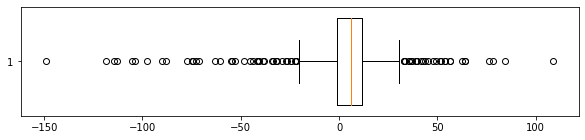

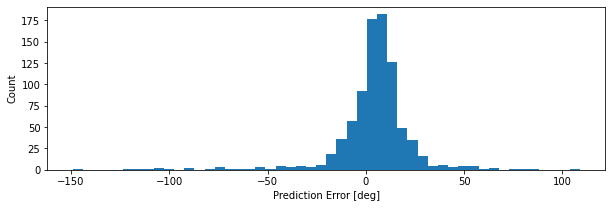

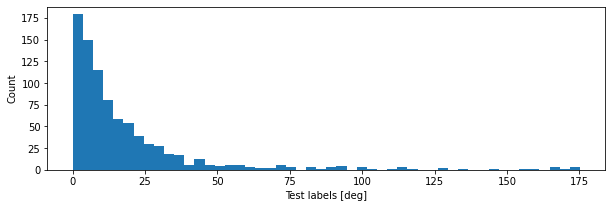

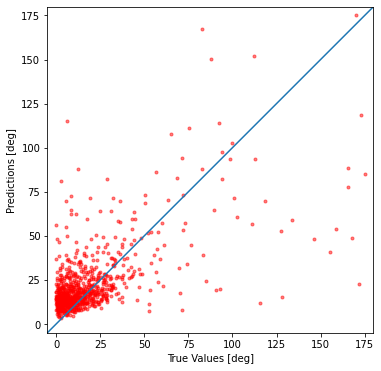

In [0]:
# Evaluate the performance of the model by calculating:
# - The percentage of predictions within an acceptable error margin
# - The root-mean-square error (RMSE) of the predicted and actual angles of rotation

prediction_error = test_predictions - test_labels

threshold = 10 #(degrees)
num_correct = sum(abs(prediction_error) < threshold)
accuracy = num_correct/len(test_images)
print('accuracy:', accuracy)

squares = prediction_error**2
rmse = np.sqrt(np.mean(squares))
print('rmse:', rmse)

# Plot error boxplot
plt.figure(figsize=(10,2))
plt.boxplot(prediction_error, vert=False, widths=0.8)
plt.show()

# Plot histogram error plot
plt.figure(figsize=(10,3))
plt.hist(prediction_error, bins = 50)
plt.xlabel("Prediction Error [deg]")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,3))
plt.hist(test_labels, bins = 50)
plt.xlabel("Test labels [deg]")
plt.ylabel("Count")
plt.show()

# Plot predictions
plt.figure(figsize=(6,6))
plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, c='r', marker='.', alpha=0.5)
plt.xlabel('True Values [deg]')
plt.ylabel('Predictions [deg]')
lims = [-5, 180]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()

In [0]:
## Functions for creating synthetic images

def add_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A):
    x, y = np.meshgrid(range(im.shape[0]), range(im.shape[1]))
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = -np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    g = A*np.exp(-(a*(x-mu_x)**2 + 2*b*(x-mu_x)*(y-mu_y) + c*(y-mu_y)**2)) # 2D Gaussian general formula (pixel values)
    return im + g

def add_asym_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A):
    '''
    Adds an asymmetric Gaussian (different sigmas on either side of peak)
    around the peak (mu_x, mu_y), at angle theta to the vertical
    '''
    # sets dimensions to be odd, so is a central pixel for rotation about
    x_dim_, y_dim_ = im.shape[0]//2*2-1, im.shape[1]//2*2-1
    # otherwise can cause unwanted asymmetries in image when multiple Gaussians (i.e.tails)
    x, y = np.meshgrid(range(x_dim_), range(y_dim_)) # pixel coordinates
    d, e = 1, 2.4 # sigma values either side of peak
    
    a = 1/(2*sigma_x**2)
    c = np.empty_like(y, dtype=float)
    c[y>y_dim_//2] = 1/(2*(d*sigma_y)**2)
    c[y<=y_dim_//2] = 1/(2*(e*sigma_y)**2)
    
    g = A*np.exp(-(a*(x-y_dim_//2)**2 + c*(y-y_dim_//2)**2)) # 2D Gaussian function
    g = rotate(g, theta*180/np.pi, reshape=False) # rotate so at correct angle
    g = shift(g, [mu_y-y_dim_//2, mu_x-x_dim_//2]) # shift peak from center to (mu_x, mu_y)
    g = np.pad(g, [[0,y_dim_%2],[0,x_dim_%2]], mode='constant') # pad array so same dimensions as im
    return im + g

def add_noise(im):
    x_dim, y_dim = im.shape
    return im + 0.1*np.random.rand(x_dim,y_dim)
    
def normalise(im):
    return 2*(im-np.min(im))/np.ptp(im)-1 # [-1,1]

def sim_agn(dim=crop_size, fr_type=1, rot=True):
    
    # Random variables
    cent_x, cent_y = np.random.normal(dim//2, scale=3, size=2) # black hole location
    angle = np.random.rand()*np.pi
    
    if fr_type==1:
        d = np.random.rand()*(dim/2)*0.3 + 4 # distance of jets centre from black hole
        tail_halo_sigma = np.random.rand()*2.5
        tail_halo_brightness = np.random.rand()
    if fr_type==2:
        d = np.random.rand()*(dim/2)*0.5 + 4 # distance of jets centre from black hole
        tail_halo_sigma = np.random.rand()*4+1
        tail_halo_brightness = np.random.rand()
    halo_kw = [tail_halo_sigma, tail_halo_sigma, 0, tail_halo_brightness]
    
    # tail locations
    tail1_x = cent_x - d
    tail1_y = cent_y
    tail2_x = cent_x + d*np.cos(angle)
    tail2_y = cent_y + d*np.sin(angle)
    
    # Create blank image and add black hole and tails at calculated coords
    image = np.zeros((dim, dim))
    A = np.random.rand(1)+0.5
    image = add_asym_gauss(image, tail1_x, tail1_y, 1.5, 2.5, (-1)**fr_type*(-np.pi/2), A)
    image = add_asym_gauss(image, tail2_x, tail2_y, 1.5, 2.5, (-1)**fr_type*(np.pi/2)-angle, A+np.random.normal(0,0.1))
    image = add_gauss(image, cent_x, cent_y, 1.5, 1.5, 0, np.random.rand())
    image = add_gauss(image, tail1_x, tail1_y, *halo_kw)
    image = add_gauss(image, tail2_x, tail2_y, *halo_kw)
    #image = add_noise(image)
    image = normalise(image)
    if rot: image = rotate(image, np.random.rand()*360, reshape=False, cval=-1)
    return image, angle*180/np.pi

Time for synthetic data generation: 00:55


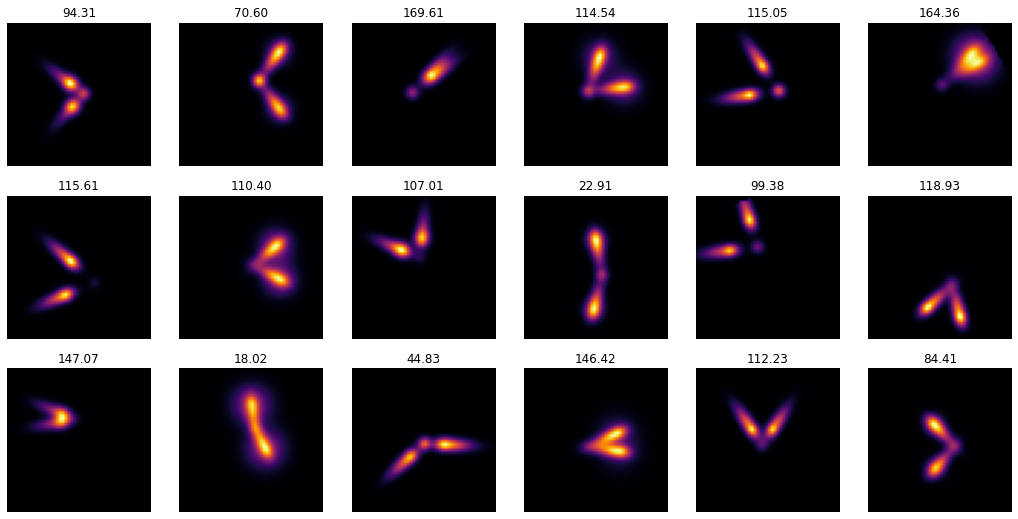

In [17]:
## Create training set of synthetic images

#synthetic_size = 100
start_time = time.time()

synthetic_images = np.empty((synthetic_size, crop_size, crop_size))
synthetic_labels = np.empty(synthetic_size)
for i in range(synthetic_size):
    synthetic_images[i], synthetic_labels[i] = sim_agn(fr_type=i%2+1)

print('Time for synthetic data generation: {:02d}:{:02d}'.format(*divmod(round(time.time()-start_time), 60)))
show_labelled_images(synthetic_images, synthetic_labels)

synthetic_images = synthetic_images[..., tf.newaxis].astype('float32')
# Combine real and synthetic data into dataset
combined_images = np.concatenate((aug_train_images, synthetic_images))
combined_labels = np.concatenate((aug_train_labels, synthetic_labels))

train_ds = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels))
train_ds = train_ds.shuffle(len(combined_images))

In [18]:
## Train model with synthetic data

input_shape = test_images.shape[1:]
print('input shape:',input_shape)

# Alhassan model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(194, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(194, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

history = model.fit(train_ds.batch(batch_size), validation_data=test_ds.batch(batch_size), epochs=epochs)
print('\n')
model.evaluate(test_ds.batch(32), verbose=2)

input shape: (50, 50, 1)
Train for 313 steps, validate for 7 steps
Epoch 1/30
313/313 [==============================] - 13s 40ms/step - loss: 2681.1060 - mae: 41.4417 - mse: 2680.9451 - val_loss: 966.3824 - val_mae: 25.2239 - val_mse: 961.2199
Epoch 2/30
313/313 [==============================] - 6s 19ms/step - loss: 2095.4751 - mae: 35.4067 - mse: 2097.0730 - val_loss: 590.2723 - val_mae: 15.9642 - val_mse: 582.2408
Epoch 3/30
313/313 [==============================] - 6s 19ms/step - loss: 1392.3456 - mae: 27.2867 - mse: 1393.2153 - val_loss: 441.3000 - val_mae: 13.2397 - val_mse: 441.4691
Epoch 4/30
313/313 [==============================] - 6s 19ms/step - loss: 1142.7777 - mae: 24.3700 - mse: 1143.8053 - val_loss: 420.2858 - val_mae: 13.2915 - val_mse: 417.8239
Epoch 5/30
313/313 [==============================] - 6s 19ms/step - loss: 1020.8733 - mae: 22.7688 - mse: 1020.6287 - val_loss: 603.3050 - val_mae: 18.1547 - val_mse: 605.1004
Epoch 6/30
313/313 [===========================

[337.60754959671584, 11.508404, 339.23022]

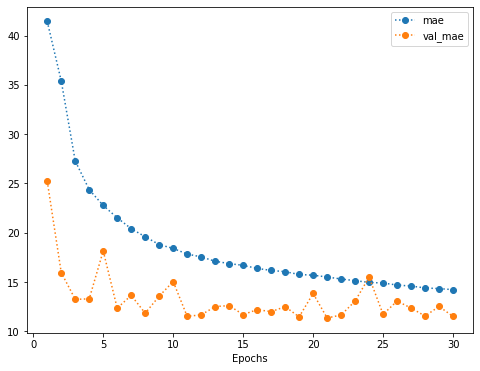

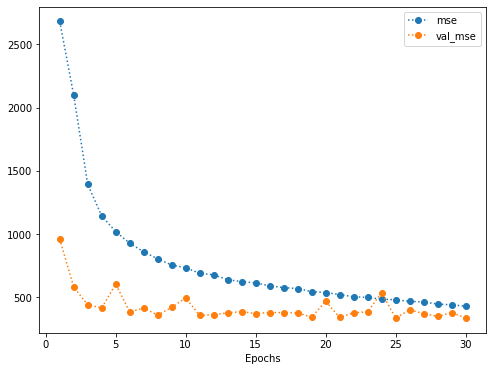

In [19]:
## Plot metrics

history_dict = history.history
#print('history_dict keys:', history_dict.keys())

# loss = history_dict['loss']
# val_loss = history_dict['val_loss']
# mae = history_dict['mae']
# val_mae = history_dict['val_mae']
# mse = history_dict['mse']
# val_mse = history_dict['val_mse']

def plot_metric(epochs, metrics):
    plt.figure(figsize=(8,6))
    for m in metrics:
        metric = history_dict[m]
        plt.plot(range(1,epochs+1), metric, 'o:', label=m)
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# plot_metric(epochs, ('loss', 'val_loss'))
plot_metric(epochs, ('mae', 'val_mae'))
plot_metric(epochs, ('mse', 'val_mse'))

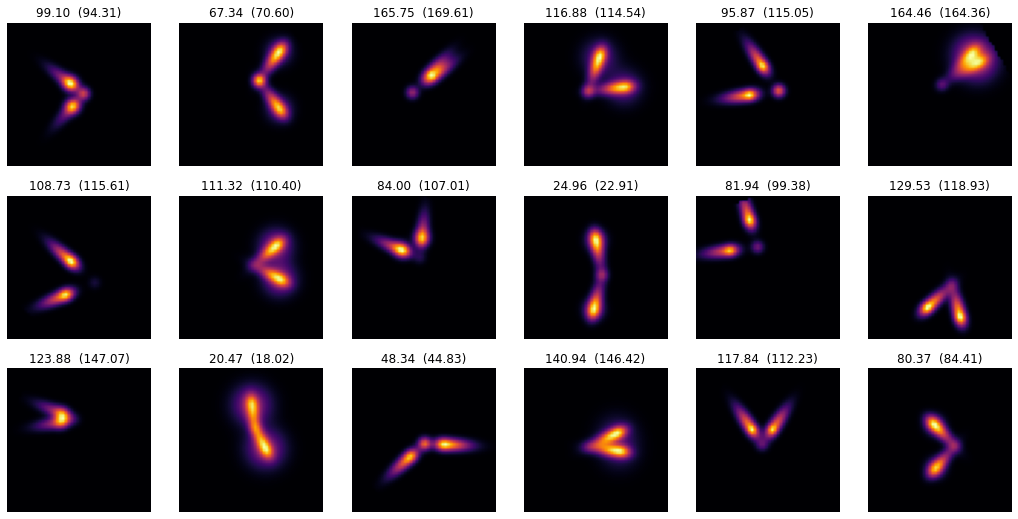

In [23]:
test_predictions = model.predict(synthetic_images)
test_predictions = np.squeeze(test_predictions)

def show_image_predictions(images, labels, predictions, num=18, log=False):
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(18,3*rows))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i,:,:,0]
        if log: 
            image = image-np.min(image)+0.01 # make all pixel values positive for log color scale
            plt.imshow(image, cmap='inferno', norm=colors.LogNorm())
        else:
            plt.imshow(image, cmap='inferno')
        plt.title('{:.2f}  ({:.2f})'.format(predictions[i], labels[i]))
        plt.axis('off')
    plt.show()

show_image_predictions(synthetic_images, synthetic_labels, test_predictions)